In [36]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/mvries/Documents/GitHub/cellshape-generate/cellshape_generate')

from cellshape_generate import CloudVAE, count_parameters

In [37]:
model = CloudVAE(num_features=16, decoder_type="foldingnetbasic").cuda()
print('Number of parameters: {}'.format(count_parameters(model)))

Number of parameters: 1172358


In [38]:
from pathlib import Path
import torch

p = Path("/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/" \
         "DUDBI/DYNCESYS/mvries/ResultsAlma/cellshape-generate/nets/" \
         "dgcnn_foldingnetbasic_16_pretrained_001.pt")
checkpoint = torch.load(p)

In [39]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [40]:
from cellshape_cloud.pointcloud_dataset import SingleCellDataset
from torch.utils.data import DataLoader

df_p = Path("/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/" \
            "all_data_removedwrong_ori_removedTwo.csv")

ds_p = Path("/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/")

dataset = SingleCellDataset(
            df_p, ds_p
        )

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [41]:
model.eval()

CloudVAE(
  (encoder): DGCNNEncoder(
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (decode

In [42]:
from tqdm import tqdm

all_inputs = []
all_outputs = []
all_treatments = []
all_serials = []
all_outputs = []
all_mu = []
all_logvar = []
all_z = []
all_feats = []

for data in tqdm(dataloader):
    image, treatment, feats, serial_number = data
    inputs = image.cuda()
    output, mu, log_var, z, feats = model(inputs)
    all_inputs.append(torch.squeeze(inputs).detach().cpu().numpy())
    all_outputs.append(torch.squeeze(output).detach().cpu().numpy())
    all_treatments.append(treatment)
    all_serials.append(serial_number)
    all_mu.append(torch.squeeze(mu).detach().cpu().numpy())
    all_logvar.append(torch.squeeze(log_var).detach().cpu().numpy())
    all_z.append(torch.squeeze(z).detach().cpu().numpy())
    all_feats.append(torch.squeeze(feats).detach().cpu().numpy())

 66%|██████▌   | 42934/65500 [07:20<03:51, 97.39it/s] 


KeyboardInterrupt: 

In [44]:
model

CloudVAE(
  (encoder): DGCNNEncoder(
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (decode

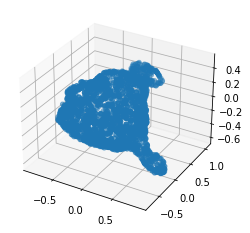

In [91]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

number = 1

input_un = all_inputs[number]


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(input_un[:,0], input_un[:,1], input_un[:,2])

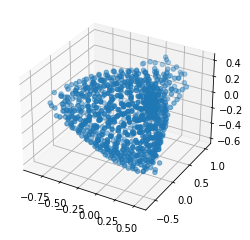

In [92]:
output_un = all_outputs[number]


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(output_un[:,0], output_un[:,1], output_un[:,2])

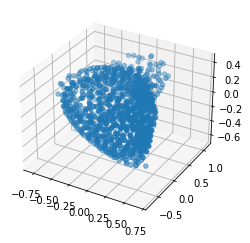

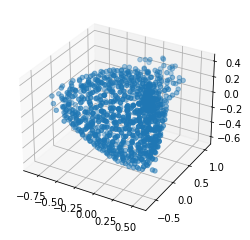

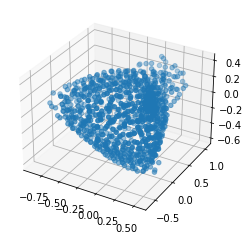

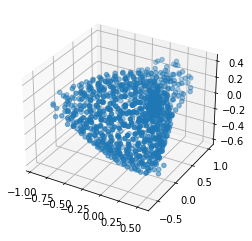

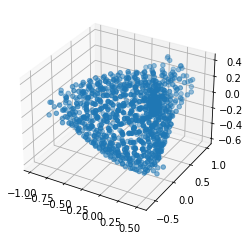

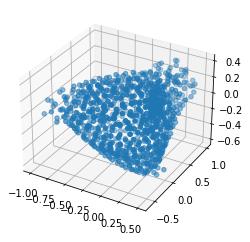

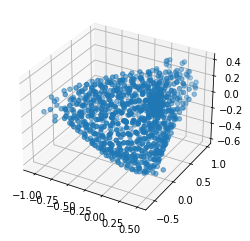

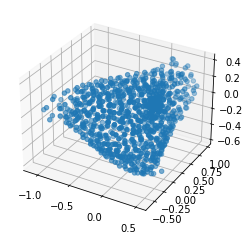

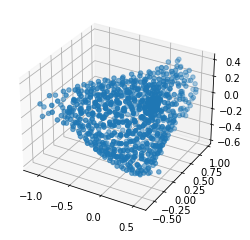

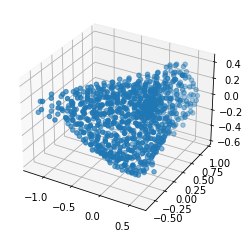

In [98]:
from scipy.stats import norm
# Get the encoded mu and logvar from encode
z = all_z[number]
# want to range the first latent code from [-3, 3]
grid_x = norm.ppf(torch.linspace(0.99, 0.05, 10))


for i in grid_x:
    z[0] = i
    out_un = model._decode(torch.unsqueeze(torch.tensor(z), 0).cuda())
    out_un = torch.squeeze(out_un).detach().cpu().numpy()
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(out_un[:,0], out_un[:,1], out_un[:,2])
    plt.show()
    plt.close()

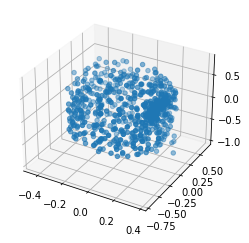

In [101]:
out_un = model._decode(torch.zeros((1,16)).cuda())
out_un = torch.squeeze(out_un).detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(out_un[:,0], out_un[:,1], out_un[:,2])
plt.show()
plt.close()

In [47]:
from torchvision.utils import make_grid

def manifold2d(d: int, **kwargs: Union[str, int]) -> torch.Tensor:
    """
    Plots a learned latent manifold in the image space
    """
    if self.num_classes > 0:
        cls = tt(kwargs.get("label", 0))
        cls = to_onehot(cls.unsqueeze(0), self.num_classes)
    grid_x = norm.ppf(torch.linspace(0.95, 0.05, d))
    grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
    loc_img_all = []
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = tt([xi, yi]).float().to(self.device).unsqueeze(0)
            if self.num_classes > 0:
                z_sample = torch.cat([z_sample, cls], dim=-1)
            d_args = (self.grid.unsqueeze(0), z_sample) if self.coord > 0 else (z_sample,)
            loc_img = self.decoder_net(*d_args)
            loc_img_all.append(loc_img.detach().cpu())
    loc_img_all = torch.cat(loc_img_all)

    grid = make_grid(loc_img_all[:, None], nrow=d,
                         padding=kwargs.get("padding", 2),
                         pad_value=kwargs.get("pad_value", 0))
    plt.figure(figsize=(8, 8))
    plt.imshow(grid[0], cmap=kwargs.get("cmap", "gnuplot"),
                   origin=kwargs.get("origin", "upper"),
                   extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    plt.show()

tensor([[-0.1581,  0.4111, -0.0770, -2.8478, -1.2299,  0.2891, -0.8498, -0.8890,
         -0.5079,  0.7962, -0.0727, -0.8535,  0.1896,  0.2992,  0.1245,  0.2505]],
       device='cuda:0', grad_fn=<AddBackward0>)
